In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import decomposition
import time
import cv2
import numpy as np
from skimage.util import img_as_float
from skimage import color, io, measure, img_as_ubyte
from skimage.measure import profile_line
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import pydicom as dicom
from skimage.morphology import erosion, dilation, opening, closing
from skimage.morphology import disk 
from scipy.spatial import distance
from skimage.transform import rotate
from skimage.filters import threshold_otsu
import glob
from sklearn.decomposition import PCA
from skimage.transform import SimilarityTransform
from skimage.transform import matrix_transform
from skimage.transform import warp
from skimage.filters import median
import math
from skimage.filters import prewitt_h
from skimage.filters import prewitt_v
from skimage.filters import prewitt
from scipy.stats import norm
from skimage import segmentation
from skimage.transform import EuclideanTransform
from skimage.filters import gaussian
from skimage import io
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.decomposition import PCA
from skimage.transform import SimilarityTransform
from skimage.transform import warp
import os
import pathlib
import random
# from auxiliaryFuns import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from skimage.util import img_as_ubyte
from IPython.display import clear_output

# Q1

In [20]:
def histogram_stretch(img_in) :
    """
    Stretches the histogram of an image 
    :param img_in: Input image
    :return: Image, where the histogram is stretched so the min values is 0 and the maximum value 255
    """
    # img_as_float will divide all pixel values with 255.0
    img_float = img_as_float(img_in)
    min_val = img_float.min()
    max_val = img_float.max()
    min_desired = 0.2                   # svarer til 0 når ganger med 255 igen
    max_desired = 0.8                   # svarer til 255 når ganger med 255 igen
	
    # Do something here
    img_out = (max_desired - min_desired)/(max_val - min_val) * (img_float - min_val) + min_desired

    # img_as_ubyte will multiply all pixel values with 255.0 before converting to unsigned byte
    return img_as_ubyte(img_out)

In [21]:
img = io.imread("/Users/estherholstoeksnebjerg/Desktop/02502 Exam/ardeche_river.jpg")
gray_img = color.rgb2gray(img)
stretched = img_as_float(histogram_stretch(gray_img))
mean_val = np.mean(stretched)
print(mean_val)
prew_img = prewitt_h(stretched)
print(np.max(np.abs(prew_img)))
bin_img = stretched > mean_val
print(np.sum(bin_img))

0.4761332057901532
0.5333333333333331
244604


# Q2

In [22]:
dir =  "/Users/estherholstoeksnebjerg/Desktop/02502 Exam/Fish/"
files = glob.glob(dir + "*.jpg")
n_samples = len(files)
height, width, channels = io.imread(files[0]).shape
n_features = height*width*channels
data_matrix = np.zeros((n_samples, n_features))
for idx, f in enumerate(files):
    data_matrix[idx, :] = io.imread(f).flatten()

mean_fish = np.mean(data_matrix, axis=0) # mean of each column (axis=0)

print("Computing PCA")
fish_pca = PCA(n_components=6)
fish_pca.fit(data_matrix)

Computing PCA


PCA(n_components=6)

In [23]:
files

['/Users/estherholstoeksnebjerg/Desktop/02502 Exam/Fish/platy.jpg',
 '/Users/estherholstoeksnebjerg/Desktop/02502 Exam/Fish/rummy.jpg',
 '/Users/estherholstoeksnebjerg/Desktop/02502 Exam/Fish/oscar.jpg',
 '/Users/estherholstoeksnebjerg/Desktop/02502 Exam/Fish/zebra.jpg',
 '/Users/estherholstoeksnebjerg/Desktop/02502 Exam/Fish/tiger.jpg',
 '/Users/estherholstoeksnebjerg/Desktop/02502 Exam/Fish/discus.jpg',
 '/Users/estherholstoeksnebjerg/Desktop/02502 Exam/Fish/kribensis.jpg',
 '/Users/estherholstoeksnebjerg/Desktop/02502 Exam/Fish/guppy.jpg',
 '/Users/estherholstoeksnebjerg/Desktop/02502 Exam/Fish/scalare.jpg',
 '/Users/estherholstoeksnebjerg/Desktop/02502 Exam/Fish/neon.jpg']

In [24]:
neon_fish = io.imread("/Users/estherholstoeksnebjerg/Desktop/02502 Exam/Fish/neon.jpg")
guppy = io.imread("/Users/estherholstoeksnebjerg/Desktop/02502 Exam/Fish/guppy.jpg")
diff = neon_fish - guppy
print(np.sum(np.square(diff)))

49557848


In [25]:
# find PCA coordinates of the missing pizza
neon_fish_flat = neon_fish.flatten()
neon_fish_flat = neon_fish_flat.reshape(1, -1)
pca_coords = fish_pca.transform(neon_fish_flat)
pca_coords = pca_coords.flatten()
# find the pizza that is most similar
components = fish_pca.transform(data_matrix)
comp_sub = components - pca_coords
pca_distances = np.linalg.norm(comp_sub, axis=1)
worst_match = np.argmax(pca_distances)
print(f"Fish least similar to neon fish, \n{worst_match} : {files[worst_match]}")

Fish least similar to neon fish, 
0 : /Users/estherholstoeksnebjerg/Desktop/02502 Exam/Fish/platy.jpg


In [26]:
explained_variance = fish_pca.explained_variance_ratio_
print(np.sum(explained_variance[0:2]))

0.46042452061426553


# Q4

In [2]:
def rotation_matrix(pitch, roll, yaw, deg = False):
    """
    Return the rotation matrix associated with the Euler angles roll, pitch, yaw.
    
    Parameters
    ----------
    pitch : float
        The rotation angle around the x-axis.
    roll : float
        The rotation angle around the y-axis.
    yaw : float
        The rotation angle around the z-axis.
    deg : bool, optional
        If True, the angles are given in degrees. If False, the angles are given
        in radians. Default: False.
    """
    if deg:
        roll = np.deg2rad(roll)
        pitch = np.deg2rad(pitch)
        yaw = np.deg2rad(yaw)

    R_x = np.array([[1, 0,             0,             0],
                    [0, np.cos(pitch),  -np.sin(pitch),  0],
                    [0, np.sin(pitch), np.cos(pitch),  0],
                    [0, 0,             0,             1]])

    R_y = np.array([[np.cos(roll), 0, np.sin(roll), 0],
                    [0, 1, 0, 0],
                    [-np.sin(roll), 0, np.cos(roll), 0],
                    [0, 0, 0, 1]])

    R_z = np.array([[np.cos(yaw),  -np.sin(yaw), 0, 0],
                    [np.sin(yaw), np.cos(yaw),  0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])

    R = np.dot(np.dot(R_x, R_y), R_z)

    return R

In [5]:
dir_in = '/Users/estherholstoeksnebjerg/Desktop/02502 Exam/'
fixed = sitk.ReadImage(dir_in + 'ImgT1_v1.nii')
mov = sitk.ReadImage(dir_in + 'ImgT1_v2.nii')

v1_array = sitk.GetArrayFromImage(fixed)
v2_array = sitk.GetArrayFromImage(mov)

# Define the roll rotation in radians
angle = -20  # degrees
pitch_radians = np.deg2rad(angle)

# Create the Affine transform and set the rotation
transform = sitk.AffineTransform(3)
rot_matrix = rotation_matrix(pitch_radians, 0, 0)[:3, :3] # SimpleITK inputs the rotation and the translation separately
transform.SetMatrix(rot_matrix.T.flatten())

# Apply the transformation to the image
mov_trans = sitk.Resample(mov, transform)
mov_trans_array = sitk.GetArrayFromImage(mov_trans)

brain_mask = v1_array > 50

sq_error = np.square(mov_trans_array[brain_mask]-v1_array[brain_mask])

print(f"mean squared error: {np.mean(sq_error)}")

NameError: name 'rotation_matrix' is not defined

In [4]:
folder_in = '/Users/estherholstoeksnebjerg/Desktop/02502 Exam/'
fixedImage = sitk.ReadImage(folder_in + 'ImgT1_v1.nii')
movingImage = sitk.ReadImage(folder_in + 'ImgT1_v2.nii')

# Define the roll rotation in radians
angle = -20  # degrees
roll_radians = np.deg2rad(angle)

# Create the Affine transform and set the rotation
transform = sitk.AffineTransform(3)
rot_matrix = rotation_matrix(0, roll_radians, 0)[:3, :3] # SimpleITK inputs the rotation and the translation separately
transform.SetMatrix(rot_matrix.T.flatten())

# centre_image = np.array(movingImage.GetSize()) / 2 - 0.5  # Image Coordinate System
# centre_world = movingImage.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System

# Apply the transformation to the image
movingImage_reg = sitk.Resample(movingImage, transform)

mask = sitk.GetArrayFromImage(fixedImage) > 50
fixedImageNumpy = sitk.GetArrayFromImage(fixedImage)
movingImageNumpy = sitk.GetArrayFromImage(movingImage_reg)

fixedImageVoxels = fixedImageNumpy[mask]
movingImageVoxels = movingImageNumpy[mask]
mse = np.mean((fixedImageVoxels - movingImageVoxels)**2)
print('Anwer: MSE = {:.2f}'.format(mse))

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "/Users/estherholstoeksnebjerg/Desktop/02502 Exam/ImgT1_v1.nii" does not exist.

In [2]:
def imshow_orthogonal_view(sitkImage, origin = None, title=None):
    """
    Display the orthogonal views of a 3D volume from the middle of the volume.

    Parameters
    ----------
    sitkImage : SimpleITK image
        Image to display.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    data = sitk.GetArrayFromImage(sitkImage)

    if origin is None:
        origin = np.array(data.shape) // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    data = img_as_ubyte(data/np.max(data))
    axes[0].imshow(data[origin[0], ::-1, ::-1], cmap='gray')
    axes[0].set_title('Axial')

    axes[1].imshow(data[::-1, origin[1], ::-1], cmap='gray')
    axes[1].set_title('Coronal')

    axes[2].imshow(data[::-1, ::-1, origin[2]], cmap='gray')
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

def overlay_slices(sitkImage0, sitkImage1, origin = None, title=None):
    """
    Overlay the orthogonal views of a two 3D volume from the middle of the volume.
    The two volumes must have the same shape. The first volume is displayed in red,
    the second in green.

    Parameters
    ----------
    sitkImage0 : SimpleITK image
        Image to display in red.
    sitkImage1 : SimpleITK image
        Image to display in green.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    vol0 = sitk.GetArrayFromImage(sitkImage0)
    vol1 = sitk.GetArrayFromImage(sitkImage1)

    if vol0.shape != vol1.shape:
        raise ValueError('The two volumes must have the same shape.')
    if np.min(vol0) < 0 or np.min(vol1) < 0: # Remove negative values - Relevant for the noisy images
        vol0[vol0 < 0] = 0
        vol1[vol1 < 0] = 0
    if origin is None:
        origin = np.array(vol0.shape) // 2

    sh = vol0.shape
    R = img_as_ubyte(vol0/np.max(vol0))
    G = img_as_ubyte(vol1/np.max(vol1))

    vol_rgb = np.zeros(shape=(sh[0], sh[1], sh[2], 3), dtype=np.uint8)
    vol_rgb[:, :, :, 0] = R
    vol_rgb[:, :, :, 1] = G

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(vol_rgb[origin[0], ::-1, ::-1, :])
    axes[0].set_title('Axial')

    axes[1].imshow(vol_rgb[::-1, origin[1], ::-1, :])
    axes[1].set_title('Coronal')

    axes[2].imshow(vol_rgb[::-1, ::-1, origin[2], :])
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

In [8]:
fixed.GetSize()

(222, 258, 222)

In [18]:
mov.GetSize()

(222, 258, 222)

In [23]:
222/2, 258/2, 222

(111.0, 129.0)

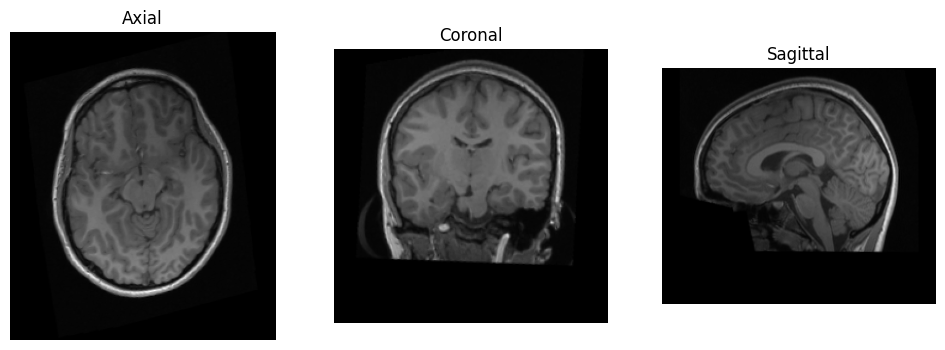

In [40]:
dir_in = '/Users/estherholstoeksnebjerg/Desktop/02502 Exam/'
fixed = sitk.ReadImage(dir_in + 'ImgT1_v1.nii')
mov = sitk.ReadImage(dir_in + 'ImgT1_v2.nii')

A = np.array([[0.98, -0.16, 0.17, 0], 
              [0.26, 0.97, 0, -15], 
              [-0.17, 0.04, 0.98, 0], 
              [0, 0, 0, 1]])[:3,:3]

# Create the Affine transform
transform = sitk.AffineTransform(3)

centre_image = np.array(mov.GetSize()) / 2 - 0.5 # Image Coordinate System
centre_world = mov.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System

transform.SetCenter(centre_world) # Set the rotation centre
transform.SetMatrix(A.flatten())

# Apply the transformation to the image
sitk_image = sitk.Resample(mov, transform)

imshow_orthogonal_view(sitk_image, origin = None)

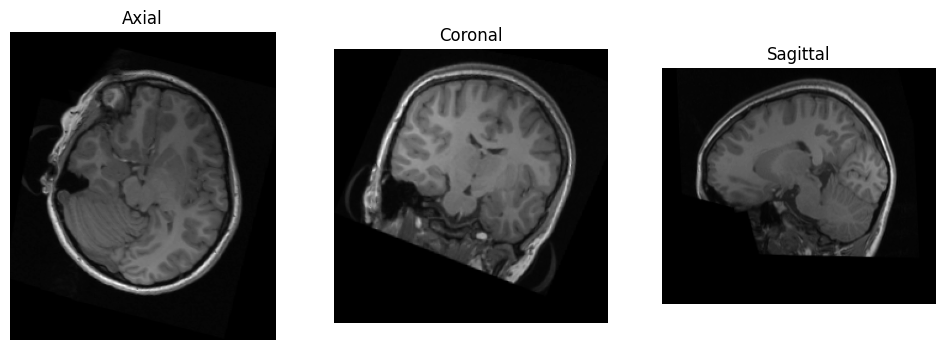

In [41]:
dir_in = '/Users/estherholstoeksnebjerg/Desktop/02502 Exam/'
fixed = sitk.ReadImage(dir_in + 'ImgT1_v1.nii')
mov = sitk.ReadImage(dir_in + 'ImgT1_v2.nii')

A = np.array([[0.98, -0.16, 0.17, 0], 
              [0.26, 0.97, 0, -15], 
              [-0.17, 0.04, 0.98, 0], 
              [0, 0, 0, 1]])[:3,:3]

# Create the Affine transform
transform = sitk.AffineTransform(3)

centre_image = np.array(mov.GetSize()) / 2 - 0.5 # Image Coordinate System
centre_world = mov.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System

transform.SetCenter(centre_world) # Set the rotation centre
transform.SetMatrix(np.linalg.inv(A).flatten())

# Apply the transformation to the image
sitk_image = sitk.Resample(mov, transform)

imshow_orthogonal_view(sitk_image, origin = None)

In [1]:
def composite2affine(composite_transform, result_center=None):
    """
    Combine all of the composite transformation's contents to form an equivalent affine transformation.
    Args:
        composite_transform (SimpleITK.CompositeTransform): Input composite transform which contains only
                                                            global transformations, possibly nested.
        result_center (tuple,list): The desired center parameter for the resulting affine transformation.
                                    If None, then set to [0,...]. This can be any arbitrary value, as it is
                                    possible to change the transform center without changing the transformation
                                    effect.
    Returns:
        SimpleITK.AffineTransform: Affine transformation that has the same effect as the input composite_transform.
    
    Source:
        https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/22_Transforms.ipynb
    """
    # Flatten the copy of the composite transform, so no nested composites.
    flattened_composite_transform = sitk.CompositeTransform(composite_transform)
    flattened_composite_transform.FlattenTransform()
    tx_dim = flattened_composite_transform.GetDimension()
    A = np.eye(tx_dim)
    c = np.zeros(tx_dim) if result_center is None else result_center
    t = np.zeros(tx_dim)
    for i in range(flattened_composite_transform.GetNumberOfTransforms() - 1, -1, -1):
        curr_tx = flattened_composite_transform.GetNthTransform(i).Downcast()
        # The TranslationTransform interface is different from other
        # global transformations.
        if curr_tx.GetTransformEnum() == sitk.sitkTranslation:
            A_curr = np.eye(tx_dim)
            t_curr = np.asarray(curr_tx.GetOffset())
            c_curr = np.zeros(tx_dim)
        else:
            A_curr = np.asarray(curr_tx.GetMatrix()).reshape(tx_dim, tx_dim)
            c_curr = np.asarray(curr_tx.GetCenter())
            # Some global transformations do not have a translation
            # (e.g. ScaleTransform, VersorTransform)
            get_translation = getattr(curr_tx, "GetTranslation", None)
            if get_translation is not None:
                t_curr = np.asarray(get_translation())
            else:
                t_curr = np.zeros(tx_dim)
        A = np.dot(A_curr, A)
        t = np.dot(A_curr, t + c - c_curr) + t_curr + c_curr - c

    return sitk.AffineTransform(A.flatten(), t, c)

In [2]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

def command_iteration(method):
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():10.5f} "
        + f": {method.GetOptimizerPosition()}"
    )

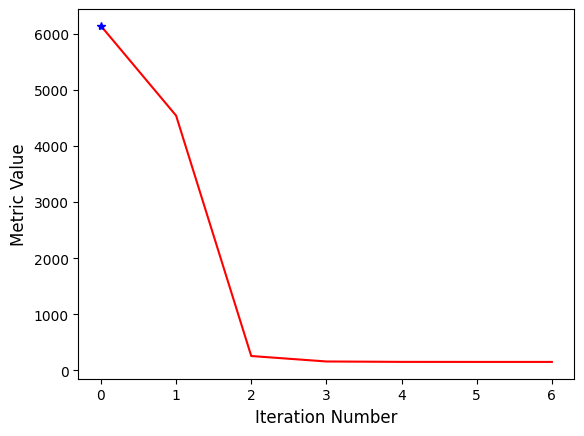

In [6]:
dir_in = '/Users/estherholstoeksnebjerg/Desktop/02502 Exam/'
fixed = sitk.ReadImage(dir_in + 'ImgT1_v1.nii')
mov = sitk.ReadImage(dir_in + 'ImgT1_v2.nii')

# Set the registration - Fig. 1 from the Theory Note
R = sitk.ImageRegistrationMethod()

# Set a one-level the pyramid scheule. [Pyramid step]
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the interpolator [Interpolation step]
R.SetInterpolator(sitk.sitkLinear)

# Set the similarity metric [Metric step]
R.SetMetricAsMeanSquares()

# Set the sampling strategy [Sampling step]
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.50)

# Set the optimizer [Optimization step]
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)

# Initialize the transformation type to rigid           !!! THIS IS WHERE WE CHANGED SOMETHING !!!
initTransform = sitk.CenteredTransformInitializer(fixed, mov, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to keep track to the optimization process 
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R)) # Print the iteration number and metric value
R.AddCommand(sitk.sitkStartEvent, start_plot) # Plot the similarity metric values across iterations
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

# Estimate the registration transformation [metric, optimizer, transform]
tform_reg = R.Execute(fixed, mov)

# Apply the estimated transformation to the moving image
ImgT1_B = sitk.Resample(mov, tform_reg)

In [7]:
tform_reg.GetParameters() # Parameters (Rx, Ry, Rz, Tx, Ty, Tz)

(-8.030794974649024e-05,
 0.2096376452137479,
 -0.0001484835619308474,
 6.244392608986368,
 0.014498710680035437,
 29.363021312265044)

In [14]:
for i in list(tform_reg.GetParameters()[0:3]):
    print(i*180/math.pi)

-0.0046013065818226
12.011352297808678
-0.008507481425706937


# Q5

In [27]:
in_dir = "/Users/estherholstoeksnebjerg/Desktop/02502 Exam/"
txt_name = "pistachio_data.txt"
x = np.loadtxt(in_dir + txt_name, comments="%")
number_of_measurements = x.shape[1]

# subtract mean
mu = np.mean(x, axis=0)
data = x - mu

# divide by standard deviation
for i in range(number_of_measurements):
    data[:,i] = data[:,i] / np.std(data[:,i])
    print(f"{i}: {np.std(data[:,i])}")

#print(f"Value of the data matrix at row=0, col=0 after subtraction of the mean and normalization: {data[0,0]}")

# do PCA manually
N = len(data[:,0])
c_x = 1/(N-1)*np.matmul(data.T,data)
values, vectors = np.linalg.eig(c_x) # Here c_x is your covariance matrix.
v_norm = values / values.sum() * 100 # explained variance
print(f"\n{np.sum(v_norm[:4])}\n")

# project data to PCA space
pc_proj = vectors.T.dot(data.T)

# sum of squared projected values, first nut
print(np.sum(np.square(pc_proj[:,0])))

print(f"\n{np.max(np.abs(c_x))}")

0: 0.9999999999999999
1: 0.9999999999999998
2: 0.9999999999999998
3: 1.0
4: 0.9999999999999998
5: 1.0
6: 1.0
7: 1.0
8: 1.0
9: 1.0
10: 1.0
11: 1.0

97.1190755748304

19.595333191942096

1.0050251256281413


# Q6

In [32]:
# ct image
in_dir = "/Users/estherholstoeksnebjerg/Desktop/02502 Exam/HeartCT/"
ct = dicom.read_file(in_dir + '1-001.dcm')
img = ct.pixel_array

# expert annotation        
myocardium_roi = io.imread(in_dir + 'MyocardiumROI.png')    
blood_roi = io.imread(in_dir + 'bloodROI.png')    
gt_blood = io.imread(in_dir + 'bloodGT.png')

# convert to boolean image
myocardium_mask = myocardium_roi > 0
blood_mask = blood_roi > 0

# organ values (hounsfield units)
myocardium_values = img[myocardium_mask]
blood_values = img[blood_mask]

mu_myocardium = np.mean(myocardium_values)
std_myocardium = np.std(myocardium_values)
mu_blood = np.mean(blood_values)
std_blood = np.std(blood_values)

r1 = mu_blood - 3*std_blood
r2 = mu_blood + 3*std_blood

print(r1,r2)

209.98726921194577 295.58624588055665


In [33]:
# minimum distance classifyer
t_1 = (mu_myocardium+mu_blood)/2
print(f"Threshold t_1 is: {t_1}\n")


Threshold t_1 is: 178.41210536488592



In [34]:
blood_bin = (img > r1) & (img < r2)
closed = closing(blood_bin, disk(3))
opened = opening(closed, disk(5))

# find BLOBs
label_img = measure.label(opened)
n_labels = label_img.max()
region_props = measure.regionprops(label_img)
# comute area and perimeter
areas = np.array([prop.area for prop in region_props])
print(len(areas))
# Criterias
min_area = 2000
max_area = 5000

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	# Find the areas and perimeters that do not fit our criteria
	if region.area >= max_area or region.area <= min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0

# compute DICE score                           # grund truth
dice_score = 1 - distance.dice(i_area.ravel(), gt_blood.ravel())
print(f"DICE score {dice_score}")

5
DICE score 0.9375729288214703


# Q7

In [35]:
cam_frame_rate = 35000000/(2400*1200*3)
proc_frame_rate = 1 / (130 * 10**(-3))    # 1 / number of seconds to process one picture
# overall system framerate of system
min(cam_frame_rate, proc_frame_rate)     # rund ned for at finde max frame rate

4.050925925925926

# Q8

In [36]:
# manually placed landmarks
dst = np.array([[1, 0], [5, 0], [2, 4], [4, 4], [3, 6]])
src = np.array([[3, 1], [6, 1], [3.6, 3], [5.4, 5], [4.4, 6]])

# do optimal similarity transform
tform = SimilarityTransform()
tform.estimate(src, dst)

#apply transform to source points
src_transform = matrix_transform(src, tform.params)

print(tform.rotation*180/math.pi)

-4.279963654888534


In [37]:
b = 1/5 * np.sum(dst,axis=0)
a = 1/5 * np.sum(src,axis=0)
b-a

array([-1.48, -0.4 ])

In [38]:
np.sum(np.square(dst-src))

15.480000000000002

# Q9

In [102]:
in_dir = "/Users/estherholstoeksnebjerg/Desktop/02502 Exam/ChangeDetection/"
im_name1 = "frame_1.jpg"
im_name2 = "frame_2.jpg"
img1 = io.imread(in_dir + im_name1)
img2 = io.imread(in_dir + im_name2)
img1_hsv = color.rgb2hsv(img1)
img2_hsv = color.rgb2hsv(img2)
S_img1 = img1_hsv[:,:,1]*255
S_img2 = img2_hsv[:,:,1]*255
S_diff = np.abs(S_img1-S_img2)
mu_diff = np.mean(S_diff)
std_diff = np.std(S_diff)
T = mu_diff + 2*std_diff
bin_img = S_diff > T

print(T)
print(f"Number of changed pixels: {np.sum(bin_img)}")

82.80872852799743
Number of changed pixels: 24695


In [104]:
label_img = measure.label(bin_img)
n_labels = label_img.max()
region_props = measure.regionprops(label_img)
# comute area and perimeter
areas = np.array([prop.area for prop in region_props])
np.max(areas)

10350.0